In [1]:
import os, math, random, time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import torch.nn as nn
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from collections import defaultdict
from __future__ import print_function, division
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def timer_start():
    global t0
    t0 = time.time()
    
def timer_end():   
    print('Time elapsed {:0.1f}s'.format(time.time() - t0))  

def display_grid(data, path, w =10, h =10, columns = 4, rows = 5):
    fig=plt.figure(figsize=(12, 8))
    for i in range(1, columns*rows +1):
        file = data[i]
        file = os.path.join(path, file)
        img = Image.open(file)
        fig.add_subplot(rows, columns, i)
        imshow(img)
    plt.show()
    
def get_best_epcoh(history):
    valid_acc = history['val_acc']
    best_epoch = valid_acc.index(max(valid_acc)) +1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

def plot_results(history):
    tr_acc = history['tr_acc']
    val_acc = history['val_acc']
    tr_loss = history['tr_loss']
    val_loss = history['val_loss']
    epochs = history['epoch']

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, tr_acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')  
    
    plt.subplot(1,2,2)
    plt.plot(epochs, tr_loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
    
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

What is Tensor?
Tensors are the building blocks for data in PyTorch. Neural networks take tensors as input and produce tensors as outputs. In fact, all operations within a neural network and during optimization are operations between tensors, and all parameters (for example, weights and biases) in a neural network are tensors. 


Tensors are the fundamental data structure in PyTorch. A tensor is an array: that is, a data structure that stores a collection of numbers that are accessible individually using an index, and that can be indexed with multiple indices.

We need at least one training dataset and one validation dataset to be able to develop and train a model.

In [4]:
transform = transforms.Compose( [                                  
                                 transforms.Resize((150,150)),
                                 transforms.RandomRotation(10),
                                 transforms.RandomHorizontalFlip(), 
                                 transforms.ToTensor(),
                                  ])

def train_val_dataset(dataset, val_split=0.3):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

dataset = ImageFolder('/content/drive/MyDrive/all/alldata', transform=transform)
print('length of dataset :',len(dataset))
datasets = train_val_dataset(dataset)
print('length of trainset :',len(datasets['train']))
print('length of validation set :',len(datasets['val']))
print(dataset)

length of dataset : 6400
length of trainset : 4480
length of validation set : 1920
Dataset ImageFolder
    Number of datapoints: 6400
    Root location: /content/drive/MyDrive/all/alldata
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
               RandomRotation(degrees=[-10.0, 10.0], resample=False, expand=False)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


To easily iterate over the data during training, we can create a data loader using the DataLoader class:

In [5]:
dataloaders = {x:DataLoader(datasets[x], 16, shuffle=True, num_workers=4) for x in ['train','val']}

In [6]:
inputs, labels = next(iter(dataloaders['train']))
print(inputs.shape, labels.shape)

torch.Size([16, 3, 150, 150]) torch.Size([16])


In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 128, 3)
        self.pool = nn.MaxPool2d(2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(21632, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 4)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.flat(x)
        x = F.leaky_relu(self.fc1(x))
        x = nn.Dropout(p=0.3)(x)
        x = F.leaky_relu(self.fc2(x))
        x = torch.softmax(self.fc3(x),dim=1)
        return x

In [8]:
def train(model, epoch, train_loader, optimizer, criterion) :   
    model.train()
    epoch_loss = correct = 0
    for i, data in enumerate(dataloaders['train'], 0):
        inputs, labels = data[0].to(device), data[1].to(device)    
        optimizer.zero_grad()
        outputs = model(inputs)
        loss =  criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)           
        correct += (predicted == labels).sum().item()  
        loss.backward()
        optimizer.step() 
        epoch_loss += outputs.shape[0] * loss.item()
    accuracy = correct / len(dataloaders['train'].dataset)
    epoch_loss = epoch_loss / len(dataloaders['train'].dataset)
    return epoch_loss, accuracy


def test(model, epoch, test_loader, optimizer, criterion):
    model.eval()
    epoch_loss = correct = 0
    with torch.no_grad():
        for i, data in enumerate(dataloaders['val'], 0):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss =    criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)           
            correct += (predicted == labels).sum().item()  
            epoch_loss += outputs.shape[0] * loss.item()
    accuracy = correct / len(dataloaders['val'].dataset)
    epoch_loss = epoch_loss / len(dataloaders['val'].dataset)
    return epoch_loss, accuracy

By default, PyTorch tensors are stored on the CPU. PyTorch tensors can be utilized on a GPU to speed up computing. This is the main advantage of tensors compared to NumPy arrays. To get this advantage, we need to move the tensors to the CUDA device. We can move tensors onto any device using the .to method:

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print('Device: ',device)
model

Device:  cuda:0


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=21632, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [10]:
%%time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

EPOCHS = 100
BATCH_SIZE=16
num_batches = math.ceil(len(datasets['train']) / BATCH_SIZE)

print('Number of Training samples {}, Batch Size {}, Num Batch {}'.format(len(datasets['train']), BATCH_SIZE, num_batches ))

history = defaultdict(list)

for epoch in range( EPOCHS):  
    timer_start()
    print('[Epoch {} of {}]'.format(epoch +1, EPOCHS), end = ' ')
    tr_loss, tr_acc = train(model, epoch, dataloaders['train'], optimizer, criterion)
    val_loss, val_acc = test(model, epoch, dataloaders['val'], optimizer, criterion)  
    timer_end()
    print('tr_loss: {:0.4f},tr_acc {:0.4f}| val_loss {:0.4f}, val_acc {:0.4f}'.format(tr_loss, tr_acc , val_loss, val_acc))
    history['epoch'].append(epoch+1)
    history['tr_loss'].append(round(tr_loss,5))
    history['tr_acc'].append(round(tr_acc,5))
    history['val_loss'].append(round(val_loss,5))
    history['val_acc'].append(round(val_acc,5))

Number of Training samples 4480, Batch Size 16, Num Batch 280
[Epoch 1 of 100] Time elapsed 623.6s
tr_loss: 1.2339,tr_acc 0.4938| val_loss 1.2171, val_acc 0.5083
[Epoch 2 of 100] Time elapsed 20.3s
tr_loss: 1.2161,tr_acc 0.4975| val_loss 1.1794, val_acc 0.5339
[Epoch 3 of 100] Time elapsed 20.3s
tr_loss: 1.1907,tr_acc 0.5290| val_loss 1.1699, val_acc 0.5620
[Epoch 4 of 100] Time elapsed 20.1s
tr_loss: 1.1847,tr_acc 0.5281| val_loss 1.1703, val_acc 0.5453
[Epoch 5 of 100] Time elapsed 20.2s
tr_loss: 1.1796,tr_acc 0.5382| val_loss 1.1641, val_acc 0.5563
[Epoch 6 of 100] Time elapsed 20.2s
tr_loss: 1.1761,tr_acc 0.5406| val_loss 1.1570, val_acc 0.5635
[Epoch 7 of 100] Time elapsed 20.0s
tr_loss: 1.1719,tr_acc 0.5422| val_loss 1.1611, val_acc 0.5641
[Epoch 8 of 100] Time elapsed 20.0s
tr_loss: 1.1637,tr_acc 0.5594| val_loss 1.1753, val_acc 0.5536
[Epoch 9 of 100] Time elapsed 20.2s
tr_loss: 1.1592,tr_acc 0.5665| val_loss 1.1365, val_acc 0.5932
[Epoch 10 of 100] Time elapsed 19.9s
tr_loss: 

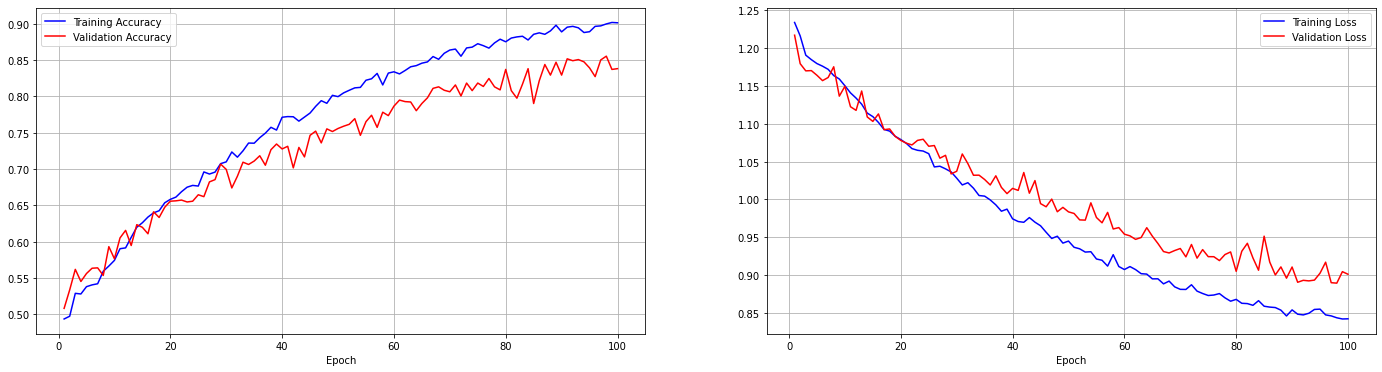

Best Validation Accuracy Score 0.85521, is for epoch 98


In [11]:
plot_results(history)
best_epoch = get_best_epcoh(history)